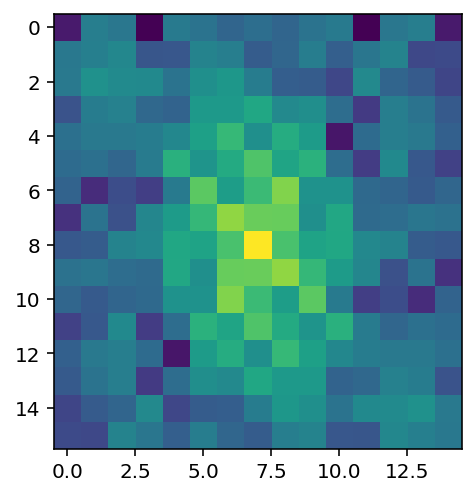

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
from torch import nn
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from dataloader import FFT_transform_PM
from time import time
import os

In [2]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]

    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [3]:
#I'm using the dataloading code that you uploaded
entries = os.listdir('Data/')

#Importing training data
train_data=[k for k in entries if 'train' in k]

X_title_train=[]
flat_data_train=[]
flat_data_train_raw=[]
X_data_train = []
X_data_train_phase=[]
X_data_train_raw = []
flat_data_train_phase=[]
for entry in train_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))
            X_data_train_raw.append(mat_r)
            
            #here we apply the FFT transform
            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_train.append(mag_val)
            X_data_train_phase.append(phase_val)
            X_title_train.append(name)
            flat_data_train.append(mag_val.flatten())
            flat_data_train_phase.append(phase_val.flatten())
            flat_data_train_raw.append(mat_r.flatten())
    #X_data_train.append(mag_val)
    #X_data.append (image)

#Importing test data
test_data=[k for k in entries if 'test' in k]
#print(test_data)
X_title_test=[]
X_data_test = []
flat_data_test=[]
X_data_test_phase=[]
X_data_test_raw=[]
flat_data_test_phase=[]
flat_data_test_raw=[]
for entry in test_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))
            X_data_test_raw.append(mat_r)

            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_test.append(mag_val)
            X_data_test_phase.append(phase_val)
            X_title_test.append(name)
            flat_data_test.append(mag_val.flatten())
            flat_data_test_phase.append(phase_val.flatten())
            flat_data_test_raw.append(mat_r.flatten())
    #X_data.append (image)

#calculate the labels of the data
res_train=[]
res_train = [sub.replace('.txt', '') for sub in X_title_train]
res_train = [sub.replace('train_', '') for sub in res_train]
res_train = [eval(i) for i in res_train]
X_train_lable=res_train
res_test=[]
res_test = [sub.replace('.txt', '') for sub in X_title_test]
res_test = [sub.replace('test_', '') for sub in res_test]
res_test = [eval(i) for i in res_test]
X_test_lable=res_test


x_train=flat_data_train
x_train_raw=flat_data_train_raw
x_train_phase= flat_data_train_phase # added the phase values 
#here I just convert nan to numbers but we might want to look deeper into where the nan values are coming from in the first place
x_train=np.nan_to_num(x_train)
x_train_raw=np.nan_to_num(x_train_raw)
x_train_phase = np.nan_to_num(x_train_phase)
#print(len(flat_data_train))
y_train_temp = X_train_lable
y_train = [float(temp_y) for temp_y in y_train_temp] #Converting to Float; for softmax at output (not mandatory)

x_test=flat_data_test
x_test_raw=flat_data_test_raw
x_test_phase = flat_data_test_phase
x_test=np.nan_to_num(x_test)
x_test_phase= np.nan_to_num(x_test_phase)
y_test_temp = X_test_lable
y_test = [float(temp_yy) for temp_yy in y_test_temp] #Converting to Float; for softmax at output (not mandatory)

#One hot encoding the class labels
enc = OneHotEncoder(handle_unknown='ignore')
enc_y_train = np.array(y_train)
enc_y_train = enc_y_train.reshape(-1, 1)

enc_y_test = np.array(y_test)
enc_y_test = enc_y_test.reshape(-1, 1)

enc.fit(enc_y_train)
# print("Categories:", enc.categories_)
n_y_train = enc.transform(enc_y_train).toarray()
n_y_test = enc.transform(enc_y_test).toarray()

In [4]:
# Layer details for the neural network
input_size = 240
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)     

Sequential(
  (0): Linear(in_features=240, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [5]:
criterion = nn.NLLLoss()
# images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)
batch_size = 100
batch_x, batch_y = next_batch(batch_size, x_train_raw, y_train)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

logps = model(batch_x_tensor)
loss = criterion(logps, batch_y_tensor)

In [6]:
print(batch_x.shape)

(100, 240)


In [7]:
print(batch_y_tensor)

tensor([5, 7, 1, 8, 6, 4, 9, 0, 8, 3, 0, 5, 0, 2, 4, 0, 3, 5, 4, 0, 2, 5, 2, 8,
        9, 4, 6, 4, 2, 4, 0, 1, 3, 6, 8, 1, 3, 7, 6, 4, 6, 0, 3, 7, 9, 4, 9, 2,
        3, 8, 8, 7, 8, 0, 8, 7, 3, 6, 7, 5, 4, 2, 4, 0, 8, 0, 7, 4, 5, 2, 8, 5,
        9, 0, 8, 4, 8, 4, 4, 2, 4, 3, 5, 3, 7, 2, 0, 6, 4, 2, 2, 4, 3, 2, 4, 8,
        6, 9, 3, 5])


In [8]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-1.5410e-04, -2.2884e-04,  1.3391e-04,  ...,  1.2277e-03,
          1.5089e-03,  1.8099e-04],
        [ 0.0000e+00, -9.6865e-04, -1.0712e-03,  ...,  9.4104e-04,
          9.4104e-04,  2.3526e-04],
        [ 0.0000e+00,  3.1953e-04, -2.3839e-04,  ...,  1.2621e-03,
          3.1554e-04,  0.0000e+00],
        ...,
        [ 2.5902e-04,  1.5188e-03,  2.7369e-03,  ...,  2.5872e-03,
          3.0002e-03,  1.9346e-03],
        [ 1.1870e-03,  9.8286e-04, -4.1834e-03,  ..., -7.4683e-03,
         -4.0647e-03, -1.0400e-03],
        [-1.1362e-04, -6.6856e-04, -3.5983e-03,  ...,  1.3991e-03,
          5.1736e-05, -9.6855e-04]])


In [9]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [10]:
print('Initial weights - ', model[0].weight)

# images, labels = next(iter(trainloader))
# images.resize_(64, 784)
batch_x, batch_y = next_batch(batch_size, x_train_raw, y_train)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(batch_x_tensor)
loss = criterion(output, batch_y_tensor)
loss.backward()
print('Gradient -', model[0].weight.grad)


Initial weights -  Parameter containing:
tensor([[ 0.0024,  0.0215, -0.0225,  ...,  0.0022, -0.0247, -0.0310],
        [-0.0605, -0.0409,  0.0518,  ..., -0.0491,  0.0158,  0.0037],
        [-0.0382,  0.0112,  0.0174,  ..., -0.0590, -0.0155,  0.0536],
        ...,
        [-0.0267,  0.0396, -0.0421,  ...,  0.0027, -0.0212,  0.0496],
        [ 0.0516,  0.0413,  0.0456,  ...,  0.0228,  0.0541, -0.0455],
        [ 0.0257,  0.0069,  0.0457,  ...,  0.0125, -0.0596,  0.0515]],
       requires_grad=True)
Gradient - tensor([[-0.0014, -0.0047, -0.0055,  ..., -0.0034, -0.0021, -0.0014],
        [ 0.0002,  0.0009,  0.0010,  ...,  0.0012,  0.0012,  0.0008],
        [ 0.0008,  0.0013,  0.0020,  ..., -0.0020, -0.0009, -0.0008],
        ...,
        [-0.0002,  0.0010,  0.0022,  ...,  0.0058,  0.0056,  0.0035],
        [ 0.0040,  0.0051,  0.0026,  ..., -0.0037, -0.0031, -0.0013],
        [ 0.0007,  0.0010,  0.0011,  ...,  0.0016,  0.0007,  0.0002]])


In [11]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0024,  0.0216, -0.0224,  ...,  0.0022, -0.0247, -0.0310],
        [-0.0605, -0.0409,  0.0518,  ..., -0.0491,  0.0158,  0.0037],
        [-0.0382,  0.0112,  0.0174,  ..., -0.0590, -0.0155,  0.0536],
        ...,
        [-0.0267,  0.0396, -0.0421,  ...,  0.0027, -0.0212,  0.0496],
        [ 0.0516,  0.0413,  0.0456,  ...,  0.0228,  0.0541, -0.0455],
        [ 0.0257,  0.0069,  0.0457,  ...,  0.0124, -0.0596,  0.0514]],
       requires_grad=True)


In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 60
for e in range(epochs):
    running_loss = 0
#     for images, labels in trainloader:
#         # Flatten MNIST images into a 784 long vector
#         images = images.view(images.shape[0], -1)
    
    batch_x, batch_y = next_batch(batch_size, x_train_raw, y_train)
    batch_x_tensor = torch.from_numpy(batch_x)
    batch_x_tensor = batch_x_tensor.to(torch.float32)

    batch_y_tensor = torch.from_numpy(batch_y)
    batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

    # Training pass
    optimizer.zero_grad()

    output = model(batch_x_tensor)
    loss = criterion(output, batch_y_tensor)

    #This is where the model learns by backpropagating
    loss.backward()

    #And optimizes its weights here
    optimizer.step()

    running_loss += loss.item()
#     else:
    print("Epoch {} - Training loss: {}".format(e, running_loss/len(batch_x_tensor)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.023166353702545165
Epoch 1 - Training loss: 0.02267876863479614
Epoch 2 - Training loss: 0.02319568395614624
Epoch 3 - Training loss: 0.023366003036499022
Epoch 4 - Training loss: 0.022455976009368897
Epoch 5 - Training loss: 0.022401344776153565
Epoch 6 - Training loss: 0.021361641883850098
Epoch 7 - Training loss: 0.021439170837402342
Epoch 8 - Training loss: 0.021274707317352294
Epoch 9 - Training loss: 0.020673274993896484
Epoch 10 - Training loss: 0.020643720626831053
Epoch 11 - Training loss: 0.020264246463775636
Epoch 12 - Training loss: 0.02015096664428711
Epoch 13 - Training loss: 0.019182127714157105
Epoch 14 - Training loss: 0.018964816331863404
Epoch 15 - Training loss: 0.01836929440498352
Epoch 16 - Training loss: 0.018055758476257323
Epoch 17 - Training loss: 0.017745774984359742
Epoch 18 - Training loss: 0.01754100441932678
Epoch 19 - Training loss: 0.016879104375839234
Epoch 20 - Training loss: 0.0164640748500824
Epoch 21 - Training loss: 0.01

In [13]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 16, 15).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Actual label = 7.0
Predicted Digit = 7


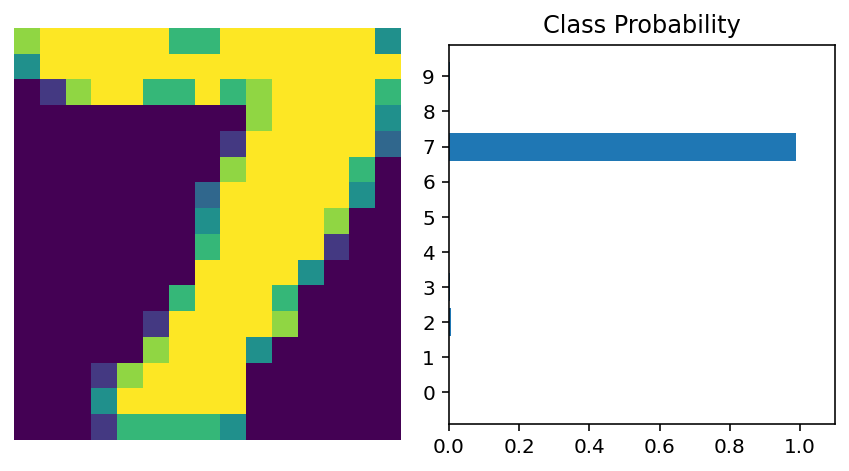

In [14]:
batch_x, batch_y = next_batch(batch_size, x_test_raw, y_test)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

# img = images[0].view(1, 784)
img = batch_x_tensor[0].view(1,240)
label = batch_y[0]
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Actual label =", label)
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 16, 15), ps)

In [15]:
batch_x, batch_y = next_batch(batch_size, x_test_raw, y_test)
batch_x_tensor = torch.from_numpy(batch_x)
batch_x_tensor = batch_x_tensor.to(torch.float32)

batch_y_tensor = torch.from_numpy(batch_y)
batch_y_tensor = batch_y_tensor.type(torch.LongTensor)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(batch_x_tensor)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy())

In [16]:
probability_arr = []
for i in range(len(probab)):
    temp_arr = list(probab[i])
    probability_arr.append(temp_arr.index(max(temp_arr)))
# probab.index(max(probab))

In [17]:
probability_arr

[4,
 4,
 3,
 8,
 8,
 4,
 5,
 1,
 2,
 5,
 3,
 7,
 5,
 2,
 4,
 6,
 7,
 3,
 9,
 2,
 6,
 2,
 5,
 6,
 6,
 4,
 9,
 7,
 0,
 3,
 4,
 6,
 4,
 2,
 8,
 1,
 7,
 5,
 6,
 0,
 7,
 4,
 9,
 6,
 0,
 2,
 7,
 0,
 9,
 5,
 2,
 7,
 3,
 8,
 3,
 3,
 7,
 0,
 2,
 6,
 5,
 0,
 0,
 7,
 3,
 5,
 7,
 4,
 2,
 9,
 8,
 8,
 5,
 1,
 5,
 5,
 6,
 9,
 0,
 4,
 0,
 2,
 2,
 5,
 9,
 0,
 1,
 5,
 2,
 8,
 6,
 4,
 1,
 4,
 9,
 6,
 2,
 6,
 1,
 6]

In [18]:
len(probability_arr)

100

In [19]:
batch_y_tensor

tensor([4, 4, 3, 8, 8, 4, 5, 1, 2, 5, 3, 3, 5, 2, 4, 6, 7, 3, 7, 2, 6, 2, 1, 4,
        6, 4, 9, 7, 0, 3, 4, 6, 4, 2, 8, 1, 7, 5, 6, 0, 7, 4, 9, 4, 0, 2, 7, 0,
        9, 5, 2, 7, 3, 8, 3, 3, 7, 0, 2, 6, 3, 0, 0, 7, 3, 5, 7, 4, 2, 9, 8, 8,
        5, 1, 5, 5, 6, 9, 0, 4, 0, 2, 3, 5, 9, 0, 1, 5, 2, 8, 6, 1, 1, 4, 9, 8,
        2, 6, 1, 6])

In [20]:
len(batch_y_tensor)

100

In [21]:
acc = sum(1 for x,y in zip(probability_arr,batch_y_tensor) if x == y) / len(probability_arr)
print("Accuracy = ", acc*100,"%")

Accuracy =  91.0 %


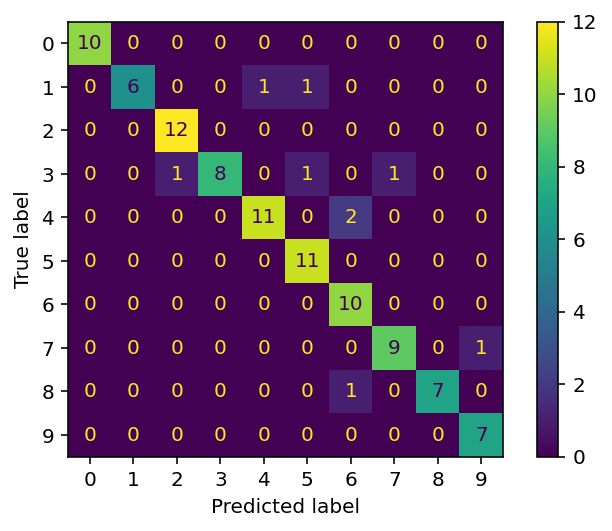

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = batch_y_tensor
y_pred = probability_arr

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()